In [26]:
import sys
if "../" not in sys.path:
    sys.path.append("../")
from kharkan.modelKAN import KharKAN
from kan import create_dataset
from kharkan.NMR import get_frequenves
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sympy as sp
def fix_powers(expr: sp.Expr) -> sp.Expr:
    """
    Convert float exponents that are integer values (e.g., 2.0) into actual integer exponents.
    """
    # Replace Pow(base, Float) where the float is integral
    return expr.replace(
        lambda e: isinstance(e, sp.Pow) and isinstance(e.exp, sp.Float) and float(e.exp).is_integer(),
        lambda e: sp.Pow(e.base, int(e.exp))
    )

In [27]:
f = lambda x: 1/np.sqrt(2)*x[:,[0]]+0.0125*x[:,[0]] * x[:,[1]]
dataset = create_dataset(f, n_var=2,ranges = [-1,1])
def f2(x):
    freqs=get_frequenves(x[:,0],x[:,1])
    return np.array(freqs)

In [28]:
# make random data so that x and 1/x are not too large
NUM_SAMPLES = 10000
xsez=-np.abs(np.random.randn(NUM_SAMPLES))
ysez=-np.abs(np.random.randn(NUM_SAMPLES)/10)
ratioX=xsez/ysez
ratioY=ysez/xsez
# filter out the samples that are too large
mask = np.abs(ratioX) < 10
mask &= np.abs(ratioY) < 10
mask &= np.abs(xsez) < 10
mask &= np.abs(ysez) < 10
xsez=xsez[mask]
ysez=ysez[mask]
ratioX=ratioX[mask]
ratioY=ratioY[mask]
answers=f2(np.array([xsez,ysez]).T)
dataset={}
dataset['train_input']=torch.tensor(np.array([xsez,ysez,ratioX,ratioY]).T).float()
dataset['train_label']=torch.tensor(answers).float()

In [29]:
kan_model = KharKAN((4,6,6,3)).cuda()
optimizer = torch.optim.Adam(kan_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
losses = []
for epoch in range(100000):
    optimizer.zero_grad()
    output = kan_model(dataset['train_input'].cuda())
    loss = criterion(output, dataset['train_label'].cuda())
    losses.append(loss.item())
    loss2=loss+kan_model.L1_loss()*loss.item()
    loss2.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")
        kan_model.anneal(100/(epoch+100))

Epoch 0, Loss 93.6469497680664
Epoch 100, Loss 1006505152.0
Epoch 200, Loss 480439072.0
Epoch 300, Loss 122994080.0
Epoch 400, Loss 14745369.0
Epoch 500, Loss 493253.53125
Epoch 600, Loss 162698.765625
Epoch 700, Loss 5950007.0
Epoch 800, Loss 3618518.25
Epoch 900, Loss 11759064.0
Epoch 1000, Loss 3248400.25
Epoch 1100, Loss 27765740.0
Epoch 1200, Loss 3838023.75
Epoch 1300, Loss 4972181.5
Epoch 1400, Loss 3007626.25
Epoch 1500, Loss 2307556.5
Epoch 1600, Loss 4300582.0
Epoch 1700, Loss 9780519.0
Epoch 1800, Loss 10695780.0
Epoch 1900, Loss 3770097.25
Epoch 2000, Loss 3667487.25
Epoch 2100, Loss 5124973.0
Epoch 2200, Loss 5137761.5
Epoch 2300, Loss 4458280.0
Epoch 2400, Loss 4249733.0
Epoch 2500, Loss 5097892.0
Epoch 2600, Loss 1977112.25
Epoch 2700, Loss 2063271.25
Epoch 2800, Loss 2738051.0
Epoch 2900, Loss 1472986.875
Epoch 3000, Loss 1577314.5
Epoch 3100, Loss 2015146.375
Epoch 3200, Loss 1449695.5
Epoch 3300, Loss 1688174.25
Epoch 3400, Loss 1490827.875
Epoch 3500, Loss 1414640.75

In [41]:
# kan_model.simplify()
# Get clean, rounded formulas directly:
formulas = kan_model.symbolic_formula(clean=True, round_digits=5)
expr=formulas['z_0']
# powers to integer
x0, x1, x2, x3 = sp.symbols('x_0 x_1 x_2 x_3')
expr_sub = expr.subs(x2, x0/x1)
expr_sub = expr_sub.subs(x3, x1/x0)
expr_open = expr_sub.expand()
# round digits -replace all numbers with 3 digits
def round_expr(expr: sp.Expr, digits: int = 5) -> sp.Expr:
    """
    Round all numerical atoms in the expression to the specified number of digits.
    """
    nums = {n: round(float(n), digits) for n in expr.atoms(sp.Number)}
    return expr.xreplace(nums)
expr_open = round_expr(expr_open, 1)
expr_open

-0.1*x_1**2.0/x_0**1.0 + 0.1*x_0*x_1**2.0 + 0.1*x_0**2.0*x_1 + 0.1*x_0**2.0*x_1**2.0 - 0.1*x_0**2.0*x_1**3.0 - 0.3*x_1 - 0.1*x_1**2.0 + 0.3*x_1**3.0 + 0.1*x_1**4.0 - 0.1*x_1**5.0

In [18]:
formulas['z_0']

0.02*x_0**2*x_1**2 + 0.02*x_0**2*x_1 + 0.01*x_0**2 + 0.02*x_0*x_1**2 + 0.02*x_0*x_1 + 0.01*x_0 - 0.21*x_1**4 - 0.42*x_1**3 - 0.97*x_1**2 - 0.77*x_1

In [ ]:
c1, c2, x = sp.symbols("c1, c2, x")
expr = c2*x*(c1*x + c2*(x/c1))
expr.expand()

c1*c2*x**2 + c2**2*x*(x/c1)**2.0

In [ ]:
train_inputs=torch.rand(2000,2)*2-1
train_labels=torch.cat(
    [train_inputs[:,:1]*train_inputs[:,:1]*1/np.sqrt(2)+0.0125*train_inputs[:,1:2]*train_inputs[:,:1],
     train_inputs[:,:1]*train_inputs[:,:1]*1/np.sqrt(2)-0.0125*train_inputs[:,1:2]*train_inputs[:,:1],
     np.sqrt(2)*train_inputs[:,:1]*train_inputs[:,:1]
     ], -1
)
dataset['train_input']=train_inputs
dataset["train_label"]=train_labels

In [ ]:
def remove_non_numeric(datastr:str):
    datastr=str(datastr)
    return ''.join([c for c in datastr if c in '1234567890./'])
def divide_data(datastr:str):
    datastr=remove_non_numeric(datastr)
    if '/' in datastr:
        x, y = datastr.split('/')
        x=float(x)
        y=float(y)
        return x/y
    return float(datastr)
def parse_float(datastr:str):
    newstr=remove_non_numeric(datastr)
    return float(newstr)
data=pd.read_csv('../data/J_v6.tsv', sep='\t', names=['Jintra', 'deltaJ'])
data['Jintra'] = data['Jintra'].apply(lambda x: divide_data(x))
# normalize each column
data['Jintra'] = data['Jintra']/20
data['deltaJ'] = data['deltaJ']/20

data['deltaJ/intra'] = data['deltaJ']/data['Jintra']
data['deltaJ*intra'] = data['deltaJ']*data['Jintra']
data['intra/deltaJ'] = data['Jintra']/data['deltaJ']
freqs=pd.read_csv('../data/Freqs_v6.tsv', sep=' ', names=['f1', 'f2', 'f3',"f1_analytical", "f2_analytical", "f3_analytical","diff1", "diff2", "diff3"])
for column in freqs.columns:
    freqs[column] = freqs[column].apply(lambda x: parse_float(x))
freqs=freqs.astype(float)
data['f1']=freqs['f1']
data['f2']=freqs['f2']
data['f3']=freqs['f3']
data["f1_analytical"]=freqs["f1_analytical"]
data["f2_analytical"]=freqs["f2_analytical"]
data["f3_analytical"]=freqs["f3_analytical"]

FileNotFoundError: [Errno 2] No such file or directory: '../data/J_v6.tsv'

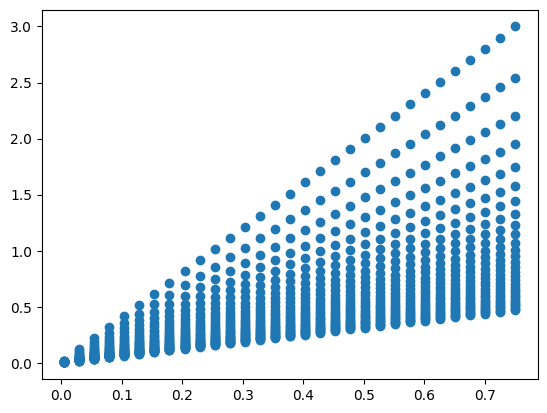

In [ ]:
plt.scatter(data["deltaJ"],data["deltaJ/intra"])
plt.xlabel="deltaJ"
plt.ylabel="deltaJ/intra"
plt.show()

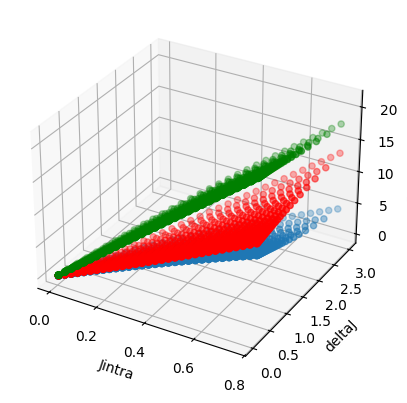

In [ ]:
#matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# labels
ax.set_xlabel('Jintra')
ax.set_ylabel('deltaJ')
ax.set_zlabel('Frequencies')
ax.scatter(data['deltaJ'], data['deltaJ/intra'], data['f1'])
ax.scatter(data['deltaJ'], data['deltaJ/intra'], data['f2'], c='r')
ax.scatter(data['deltaJ'], data['deltaJ/intra'], data['f3'], c='g')

In [ ]:
dataset['train_input']=torch.tensor(data[['deltaJ',"deltaJ/intra"]].values, dtype=torch.float32)

dataset['train_label']=torch.tensor(data[['f1', 'f2', 'f3']].values, dtype=torch.float32)
# flip xsez in train_input
train_input_flipped=-dataset['train_input'].clone()
train_input_flipped[:,0]=-train_input_flipped[:,0]
dataset['train_input']=torch.cat((dataset['train_input'],train_input_flipped),0)

dataset['train_label']=torch.cat((dataset['train_label'],-dataset['train_label']),0)
dataset['train_label']=torch.tensor(data[['f1_analytical','f2_analytical','f3_analytical']].values, dtype=torch.float32)
dataset['train_label']=torch.cat((dataset['train_label'],-dataset['train_label']),0)

In [ ]:
model=KharKAN((2,8,8,3),linear_bias=True).cuda()

In [ ]:
# training loop
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses=[]
model=model.cuda()
for epoch in range(100000):
    optimizer.zero_grad()
    output = model(dataset['train_input'].cuda())
    loss = criterion(output, dataset['train_label'].cuda())
    losses.append(loss.item())
    loss2=loss+model.L1_loss()*loss.item()
    loss2.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")
    if epoch % 1000 == 0 and epoch<6000:
        model.simplify(0.001)
        #model.anneal(1e-1/(epoch+1000)*1000)
    #if epoch==5000:
        #model.set_normalize(False)
with torch.no_grad():
    output = model(dataset['train_input'].cuda())

Epoch 0, Loss 77.52799987792969
Epoch 100, Loss 75.72551727294922
Epoch 200, Loss 56.99279022216797
Epoch 300, Loss 34.15742492675781
Epoch 400, Loss 18.85752296447754
Epoch 500, Loss 11.18620777130127
Epoch 600, Loss 9.163835525512695
Epoch 700, Loss 8.164947509765625
Epoch 800, Loss 7.377831935882568
Epoch 900, Loss 5.496844291687012
Epoch 1000, Loss 4.275300979614258
Epoch 1100, Loss 3.917905807495117
Epoch 1200, Loss 3.7154619693756104
Epoch 1300, Loss 3.5808308124542236
Epoch 1400, Loss 3.4797322750091553
Epoch 1500, Loss 3.4098150730133057
Epoch 1600, Loss 3.379737377166748
Epoch 1700, Loss 3.3655216693878174
Epoch 1800, Loss 3.3554632663726807
Epoch 1900, Loss 3.3457725048065186
Epoch 2000, Loss 3.33821439743042
Epoch 2100, Loss 3.3326430320739746
Epoch 2200, Loss 3.3279244899749756
Epoch 2300, Loss 3.3196113109588623
Epoch 2400, Loss 3.314924716949463
Epoch 2500, Loss 3.311230182647705
Epoch 2600, Loss 3.3037478923797607
Epoch 2700, Loss 3.3027141094207764
Epoch 2800, Loss 3.31

In [ ]:
with torch.no_grad():
    output = model(dataset['train_input'].cuda())

In [ ]:
with torch.no_grad():
    output = model(dataset['train_input'].cuda())
model.simplify()

# Get clean, rounded formulas directly:
formulas = model.symbolic_formula(clean=True, round_digits=2)

In [ ]:
formulas['z_0']

15.46*x_0*x_1 - 6.55*x_0*x_1**2.0 + 1.1*x_0*x_1**3.0 - 3.69*x_0 - 4.99*x_0**2.0*x_1 + 1.83*x_0**2.0*x_1**2.0 + 9.42*x_0**2.0 + 0.97*x_0**3.0*x_1 - 3.81*x_0**3.0 + 0.39*x_0**4.0 + 3.4*x_1 + 0.24*x_1**2.0 - 2.79*x_1**3.0 + 0.53*x_1**4.0 - 0.11

In [ ]:
formulas

{'z_0': 0.00545*x_0**6*x_1**2 + 0.01428*x_0**6*x_1 - 0.01285*x_0**6 + 0.06948*x_0**5*x_1**2 - 0.05083*x_0**5*x_1 - 0.06671*x_0**5 - 0.01255*x_0**4*x_1**4 + 0.12232*x_0**4*x_1**3 + 0.05329*x_0**4*x_1**2 - 0.34225*x_0**4*x_1 - 0.21529*x_0**4 - 0.03805*x_0**3*x_1**5 + 0.10626*x_0**3*x_1**4 + 0.49524*x_0**3*x_1**3 - 1.20629*x_0**3*x_1**2 + 0.70765*x_0**3*x_1 + 0.05013*x_0**3 - 0.00804*x_0**2*x_1**6 - 0.30198*x_0**2*x_1**5 + 1.6542*x_0**2*x_1**4 - 1.42581*x_0**2*x_1**3 - 3.45523*x_0**2*x_1**2 + 5.54986*x_0**2*x_1 + 1.19815*x_0**2 + 0.05424*x_0*x_1**7 - 0.4728*x_0*x_1**6 + 0.84351*x_0*x_1**5 + 2.01115*x_0*x_1**4 - 5.42593*x_0*x_1**3 - 3.0835*x_0*x_1**2 + 11.50964*x_0*x_1 + 1.52025*x_0 + 0.03277*x_1**8 - 0.15571*x_1**7 - 0.17852*x_1**6 + 1.47311*x_1**5 + 0.21495*x_1**4 - 5.24335*x_1**3 + 0.34556*x_1**2 + 6.5351*x_1 - 0.28719,
 'z_1': 0.0034*x_0**6*x_1**2 + 0.00487*x_0**6*x_1 - 0.00429*x_0**6 + 0.03755*x_0**5*x_1**2 - 0.04899*x_0**5*x_1 - 0.01313*x_0**5 - 0.00824*x_0**4*x_1**4 + 0.10928*x_0**4

In [ ]:
%matplotlib inline
# plot the 3d surface and compare it with data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# labels
ax.set_xlabel('Jintra')
ax.set_ylabel('deltaJ')
ax.set_zlabel('Frequencies')
x_0=data["Jintra"]
x_1=data["deltaJ"]
pred_fn=lambda x_0,x_1: 3.5314626939915871e-6*x_0**8 - 0.00011683513834546518*x_0**7*x_1 + 3.3446132423629935e-5*x_0**7 + 0.00017204490813877817*x_0**6*x_1**2 + 0.00014028769424463963*x_0**6*x_1 - 5.7160996247896309e-5*x_0**6 + 0.013191870638891977*x_0**5*x_1**3 - 0.016141728443507259*x_0**5*x_1**2 + 0.010219388198773456*x_0**5*x_1 + 0.00018464461339400194*x_0**5 + 0.04379680122256686*x_0**4*x_1**4 - 0.062653700604480885*x_0**4*x_1**3 - 0.032760513446946075*x_0**4*x_1**2 - 0.003793632255959185*x_0**4*x_1 + 0.004858550978702747*x_0**4 - 0.0059403509041428353*x_0**3*x_1**5 + 0.10587025638009724*x_0**3*x_1**4 - 0.60872735809218231*x_0**3*x_1**3 + 0.36219643888877147*x_0**3*x_1**2 - 0.33251457187135226*x_0**3*x_1 + 0.045381439621871523*x_0**3 - 2.916510130162805e-5*x_0**2*x_1**6 - 0.015808538988891451*x_0**2*x_1**5 + 0.15064999174194887*x_0**2*x_1**4 - 0.77165985790052927*x_0**2*x_1**3 - 0.82786301356870185*x_0**2*x_1**2 + 1.6676206525489056*x_0**2*x_1 - 0.28014889532743362*x_0**2 + 1.4846081683740983e-5*x_0*x_1**7 + 0.00035553666230446077*x_0*x_1**6 - 0.012525221744353925*x_0*x_1**5 + 0.12002454901293273*x_0*x_1**4 - 0.57065571864810626*x_0*x_1**3 + 0.40249525694942848*x_0*x_1**2 + 11.773688889133264*x_0*x_1 + 0.35165435326893786*x_0 + 2.8209554600369031e-7*x_1**8 + 2.325917905846966e-5*x_1**7 + 0.00035504513413484448*x_1**6 - 0.0047971387895838147*x_1**5 + 0.023683308476841378*x_1**4 + 0.039063707350484634*x_1**3 - 0.55773211974022484*x_1**2 + 0.47042395259331994*x_1 - 0.078422866399356847
data['f2_predicted']=pred_fn(x_0,x_1)
# data['f2_predicted']=output[:,2].cpu().detach().numpy().flatten()
ax.scatter(data['Jintra'], data['deltaJ'], data['f1_analytical'], c='b')
ax.scatter(data['Jintra'], data['deltaJ'], data['f2_analytical'], c='black')
ax.scatter(data['Jintra'], data['deltaJ'], data['f3_analytical'], c='g')
ax.scatter(data['Jintra'], data['deltaJ'], data["f2_predicted"], c='r')
#ax.scatter(data['Jintra'], data['deltaJ'], output.cpu().numpy().flatten(), c='black')

In [ ]:
output.shape

torch.Size([961, 3])

In [ ]:
np.sqrt(((data["f2_predicted"]/20-data['f2_analytical']/20)**2).mean())

0.16673881881961553